In [2]:
%matplotlib inline
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [21]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
X.shape

(70000, 784)

Each image has 784 features, because each image is 28*28 pixels

In [22]:
y.shape

(70000,)

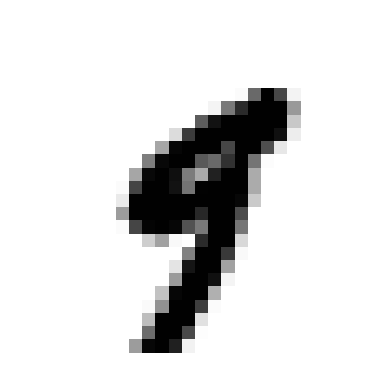

In [23]:
some_digit = X[36000]
some_digit_image = some_digit.reshape((28, 28))
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [24]:
y[36000] 

np.int64(9)

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training Binary Classifier
Let’s simplify the problem for now and only try to identify one digit — for
example, the number 7. This “7-detector” will be an example of a binary
classifier, capable of distinguishing between just two classes, 7 and not-7.

## Stochastic Gradient Descent (SGD)

In [31]:
from sklearn.linear_model import SGDClassifier

y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [36]:
some_digits = X[4000]

sgd_clf.predict([some_digits])

array([ True])

## Measuring Accuracy Using Cross-Validation

In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.98015, 0.9768 , 0.97315])

## Confusion Matrix

In [41]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)
y_train_predict

array([False, False, False, ..., False, False, False], shape=(60000,))

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7, y_train_predict)

array([[52893,   842],
       [  556,  5709]])

- TN: 52,893 (Correctly predicts negative outcome which is non7s 8=>8)
- FP: 842 (Incorrectly predicts positive outcome which is 7s 7 => 8)
- FN: 556 (Incorrectly predicts negative outcome which is non-7s  8 => 7)
- TP: 5709 (Correctly predicts positive outcome which is 7s 7=>7)

### Precision 
TP / (TP + TN)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_7, y_train_predict)

0.8714700045794536

### Recall 
TP / (TP + FN)

In [47]:
recall_score(y_train_7, y_train_predict)

0.9112529928172386

### F1 Score 
(2*(Precision * Recall)) / (Precision + Recall)

In [51]:
f1_score(y_train_7, y_train_predict) 

0.8909176029962547

### Precision/Recall Tradeoff

In [57]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([5104.63837203])

In [58]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [63]:
threshold = 6000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [100]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3,
method="decision_function")
y_scores.shape

(60000,)

In [115]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.min(), y_scores.max()

(np.float64(-163553.6213583988), np.float64(50542.598998303394))

### Precison/Recall Curve

In [103]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

In [104]:
precisions, recalls, thresholds

(array([0.10441667, 0.10441841, 0.10442015, ..., 1.        , 1.        ,
        1.        ], shape=(60001,)),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.19233839e-04, 1.59616919e-04, 0.00000000e+00], shape=(60001,)),
 array([-163553.6213584 , -158029.26042494, -154404.49551557, ...,
          46400.1804044 ,   49024.51813315,   50542.5989983 ],
       shape=(60000,)))

In [105]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

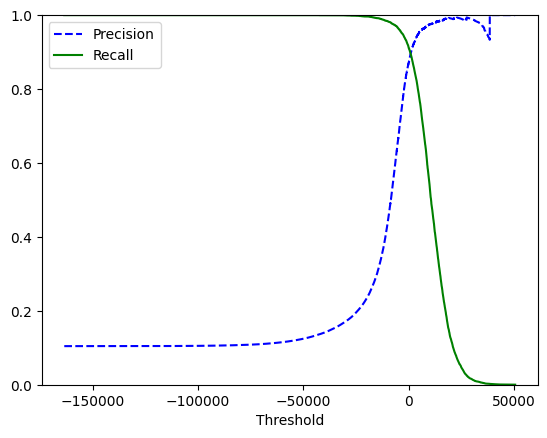

In [106]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [108]:
(y_train_predict == (y_scores > 0)).all()

np.True_

In [116]:
y_train_pred_1 = (y_scores > -5000)

In [117]:
precision_score(y_train_7, y_train_pred_1)

0.6653820744329443

In [118]:
recall_score(y_train_7, y_train_pred_1)

0.9645650438946528

In [121]:
y_train_pred_2 = (y_scores > 10000)

In [122]:
precision_score(y_train_7, y_train_pred_2)

0.9749198016914552

In [123]:
recall_score(y_train_7, y_train_pred_2)

0.5335993615323225

## The ROC Curve
- TPR: How often the model correctly predicts the positive cases as positive
- FPR: How often the model incorrectly predicts the negative cases as positive

In [127]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

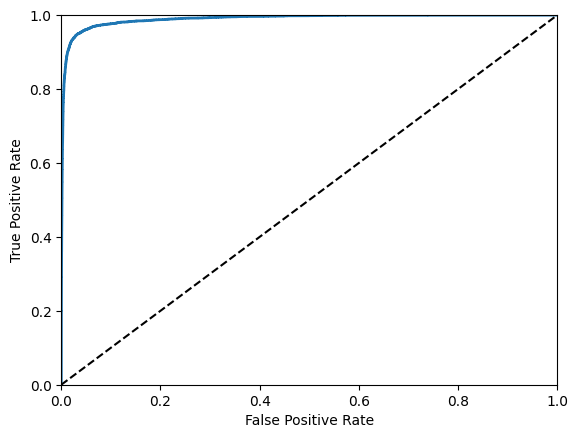

In [129]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Higher the curve better the model

## The ROC AUC Curve

In [130]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_7, y_scores)

0.9897476479822392

In [131]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3,
method="predict_proba")

In [132]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_7,y_scores_forest)

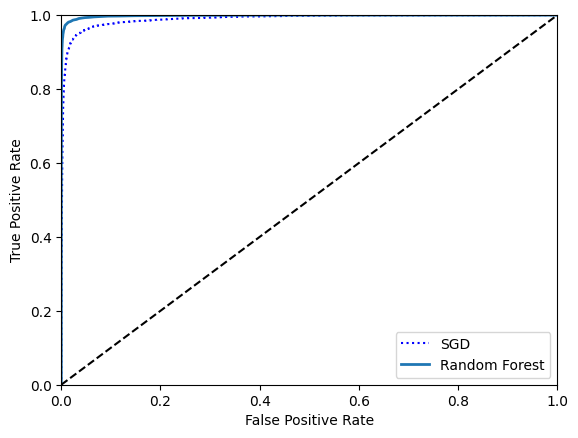

In [139]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [141]:
roc_auc_score(y_train_7, y_scores), roc_auc_score(y_train_7, y_scores_forest)

(0.9897476479822392, 0.9983879181264862)

According to roc scores, random forest performs better than SGD

# Training Multiclass Classifers

Whereas binary classifiers distinguish between two classes, multiclass
classifiers (also called multinomial classifiers) can distinguish between
more than two classes.